# Description

See description in `10-gtex_v8-no_covars-gls_full_corrs.ipynb`.

Here we used a subset of the correlation matrix using closeby genes only (within a distance of 5mb).

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis
from phenoplier_plots import qqplot

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "1000g_eur"
    / "no_covars"
    / "_corrs_5mb"
    / "gls-gtex_v8_mashr-sub_corr"
)
display(INPUT_DIR)
assert INPUT_DIR.exists()

PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/no_covars/_corrs_5mb/gls-gtex_v8_mashr-sub_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results):
    lv_code = None
    lvs = results["lv"].unique()
    if lvs.shape[0] == 1:
        lv_code = lvs[0]

    traits = results["phenotype"].unique()

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = qqplot(results[PVALUE_COLUMN])
        if lvs.shape[0] == 1:
            ax.set_title(f"{lv_code} - {traits.shape[0]} traits")
        else:
            ax.set_title(f"{lvs.shape[0]} LVs - {traits.shape[0]} traits")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/no_covars/_corrs_5mb/gls-gtex_v8_mashr-sub_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/no_covars/_corrs_5mb/gls-gtex_v8_mashr-sub_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/no_covars/_corrs_5mb/gls-gtex_v8_mashr-sub_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/no_covars/_corrs_5mb/gls-gtex_v8_mashr-sub_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/no_covars/_corrs_5mb/gls-gtex_v8_mashr-sub_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV136,0.398517,0.125578,3.173469,0.001513,0.000757,random.pheno988
1,LV816,0.329611,0.124685,2.643558,0.008224,0.004112,random.pheno988
2,LV175,0.329518,0.124846,2.639406,0.008325,0.004163,random.pheno988
3,LV116,0.343291,0.130287,2.634891,0.008437,0.004218,random.pheno988
4,LV585,0.317115,0.125007,2.536782,0.011211,0.005606,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.05573657548125633

# QQ-plot

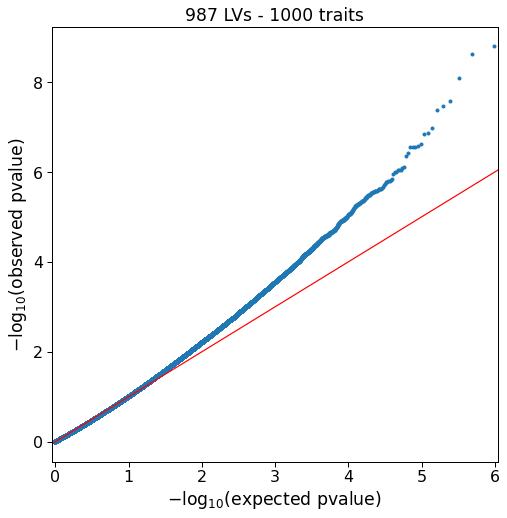

In [18]:
qqplot_unif(dfs)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.006,0.022,0.062
1,LV10,0.013,0.034,0.069
2,LV100,0.013,0.054,0.084
3,LV101,0.011,0.039,0.082
4,LV102,0.013,0.057,0.082


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.014756,0.055737,0.102466
std,0.005113,0.012726,0.018641
min,0.001000,0.016000,0.053000
25%,0.011000,0.047000,0.090000
50%,0.015000,0.055000,0.102000
75%,0.018000,0.063000,0.115000
max,0.035000,0.111000,0.178000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(97, 4)

,lv,1,5,10
532,LV579,0.014,0.049,0.102
214,LV292,0.013,0.049,0.108
746,LV771,0.014,0.049,0.097
300,LV37,0.011,0.049,0.097
680,LV711,0.015,0.049,0.089
666,LV7,0.011,0.049,0.095
665,LV699,0.015,0.049,0.101
346,LV410,0.012,0.049,0.088
639,LV675,0.011,0.049,0.099
418,LV476,0.014,0.049,0.091


,lv,1,5,10
511,LV56,0.011,0.051,0.105
148,LV232,0.009,0.051,0.096
899,LV909,0.013,0.051,0.115
454,LV508,0.018,0.051,0.102
191,LV271,0.013,0.051,0.104
199,LV279,0.014,0.051,0.100
204,LV283,0.010,0.051,0.098
754,LV779,0.012,0.051,0.092
608,LV647,0.011,0.051,0.098
525,LV572,0.016,0.051,0.095


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(324, 4)

,lv,1,5,10
752,LV777,0.016,0.083,0.150
980,LV982,0.021,0.084,0.144
310,LV379,0.024,0.084,0.126
253,LV327,0.025,0.085,0.132
672,LV704,0.019,0.085,0.153
369,LV431,0.022,0.086,0.138
151,LV235,0.028,0.086,0.134
892,LV902,0.030,0.086,0.140
720,LV748,0.023,0.087,0.132
341,LV406,0.018,0.087,0.133


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
937,LV45,-0.227702,0.141291,-1.611576,0.107103,0.946448,random.pheno988
1244,LV45,0.077580,0.141518,0.548200,0.583573,0.291787,random.pheno589
2146,LV45,0.127083,0.141302,0.899371,0.368488,0.184244,random.pheno385
3533,LV45,-0.030892,0.141236,-0.218727,0.826870,0.586565,random.pheno5
4408,LV45,-0.003102,0.141285,-0.021953,0.982486,0.508757,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.011

In [32]:
show_prop(results, 0.05)

0.069

In [33]:
show_prop(results, 0.10)

0.138

In [34]:
show_prop(results, 0.15)

0.189

In [35]:
show_prop(results, 0.20)

0.237

### QQplot

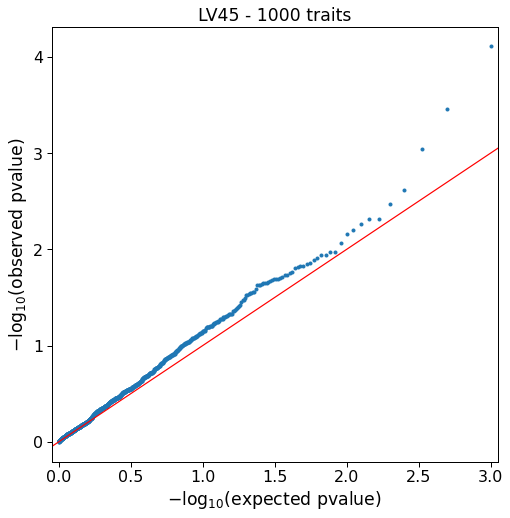

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
552,LV234,-0.038791,0.143873,-0.269623,0.787459,0.606270,random.pheno988
1876,LV234,-0.181200,0.143999,-1.258347,0.208312,0.895844,random.pheno589
2919,LV234,-0.233408,0.143790,-1.623254,0.104584,0.947708,random.pheno385
3653,LV234,-0.076928,0.143791,-0.534998,0.592670,0.703665,random.pheno5
4362,LV234,0.018453,0.143830,0.128297,0.897918,0.448959,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.014

In [43]:
show_prop(results, 0.05)

0.052

In [44]:
show_prop(results, 0.10)

0.084

In [45]:
show_prop(results, 0.15)

0.118

In [46]:
show_prop(results, 0.20)

0.154

### QQplot

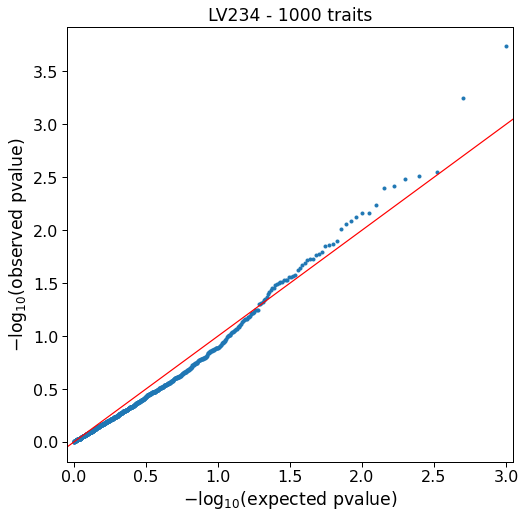

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
250,LV847,0.076561,0.141375,0.541545,0.588150,0.294075,random.pheno988
1536,LV847,-0.039704,0.141617,-0.280364,0.779207,0.610396,random.pheno589
2771,LV847,-0.124539,0.141374,-0.880919,0.378395,0.810803,random.pheno385
3429,LV847,0.006193,0.141331,0.043818,0.965051,0.482525,random.pheno5
4573,LV847,-0.057708,0.141384,-0.408167,0.683165,0.658418,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.022

In [54]:
show_prop(results, 0.05)

0.068

In [55]:
show_prop(results, 0.10)

0.131

In [56]:
show_prop(results, 0.15)

0.196

In [57]:
show_prop(results, 0.20)

0.232

### QQplot

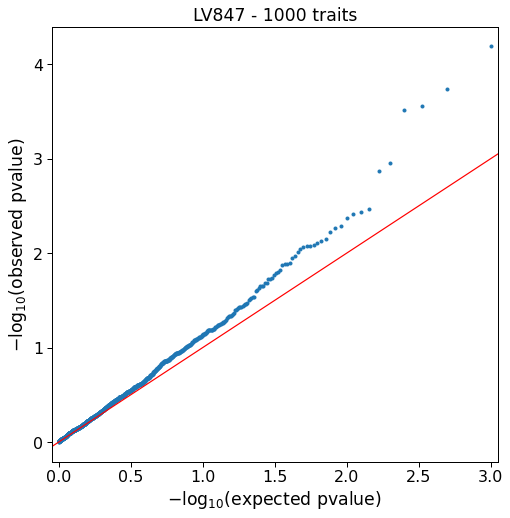

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
956,LV110,-0.260065,0.138451,-1.878395,0.060372,0.969814,random.pheno988
1691,LV110,-0.095739,0.138605,-0.690735,0.489757,0.755121,random.pheno589
2809,LV110,-0.136105,0.138451,-0.983053,0.325618,0.837191,random.pheno385
3586,LV110,-0.046314,0.138420,-0.334593,0.737943,0.631028,random.pheno5
4934,LV110,-0.344456,0.138378,-2.489240,0.012827,0.993587,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.014

In [65]:
show_prop(results, 0.05)

0.051

In [66]:
show_prop(results, 0.10)

0.098

In [67]:
show_prop(results, 0.15)

0.148

In [68]:
show_prop(results, 0.20)

0.206

### QQplot

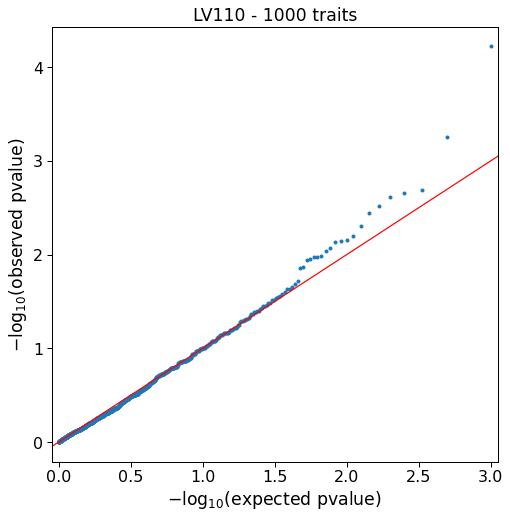

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
232,LV769,0.077792,0.124954,0.622568,0.533591,0.266795,random.pheno988
1299,LV769,0.049183,0.124956,0.393605,0.693886,0.346943,random.pheno589
2521,LV769,-0.021786,0.124966,-0.174337,0.861606,0.569197,random.pheno385
3877,LV769,-0.164972,0.124843,-1.321430,0.186405,0.906797,random.pheno5
4918,LV769,-0.236652,0.124929,-1.894291,0.058231,0.970884,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.023

In [76]:
show_prop(results, 0.05)

0.071

In [77]:
show_prop(results, 0.10)

0.135

In [78]:
show_prop(results, 0.15)

0.183

In [79]:
show_prop(results, 0.20)

0.238

### QQplot

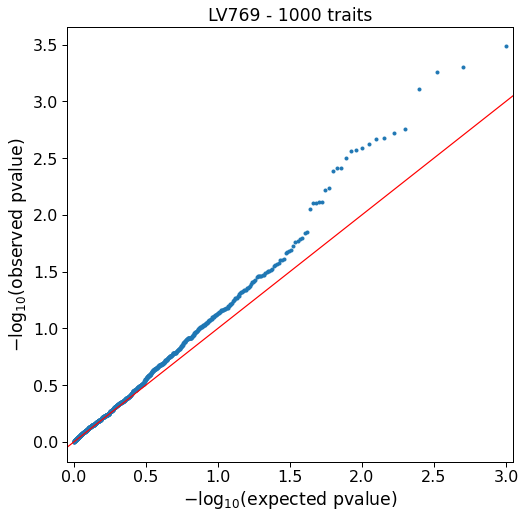

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
95,LV800,0.179446,0.149212,1.202628,0.229165,0.114582,random.pheno988
1398,LV800,0.018065,0.149185,0.121090,0.903623,0.451812,random.pheno589
2814,LV800,-0.149549,0.149158,-1.002625,0.316079,0.841960,random.pheno385
3690,LV800,-0.094190,0.149032,-0.632010,0.527403,0.736299,random.pheno5
4390,LV800,0.008703,0.149174,0.058343,0.953477,0.476739,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.022

In [87]:
show_prop(results, 0.05)

0.069

In [88]:
show_prop(results, 0.10)

0.112

In [89]:
show_prop(results, 0.15)

0.159

In [90]:
show_prop(results, 0.20)

0.206

### QQplot

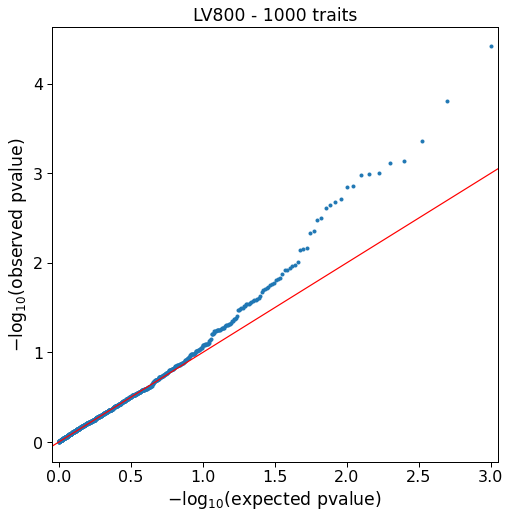

In [91]:
qqplot_unif(results)

## LV806

In [92]:
lv_code = "LV806"

In [93]:
results = dfs[dfs["lv"] == lv_code]

In [94]:
results.shape

(1000, 7)

In [95]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
718,LV806,-0.085868,0.127458,-0.673696,0.500528,0.749736,random.pheno988
1332,LV806,0.036411,0.127476,0.285632,0.775169,0.387585,random.pheno589
2100,LV806,0.139811,0.127514,1.096436,0.272929,0.136465,random.pheno385
3694,LV806,-0.081669,0.127362,-0.641237,0.521392,0.739304,random.pheno5
4219,LV806,0.068308,0.127466,0.535892,0.592052,0.296026,random.pheno74


In [96]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [97]:
show_prop(results, 0.01)

0.009

In [98]:
show_prop(results, 0.05)

0.038

In [99]:
show_prop(results, 0.10)

0.081

In [100]:
show_prop(results, 0.15)

0.108

In [101]:
show_prop(results, 0.20)

0.155

### QQplot

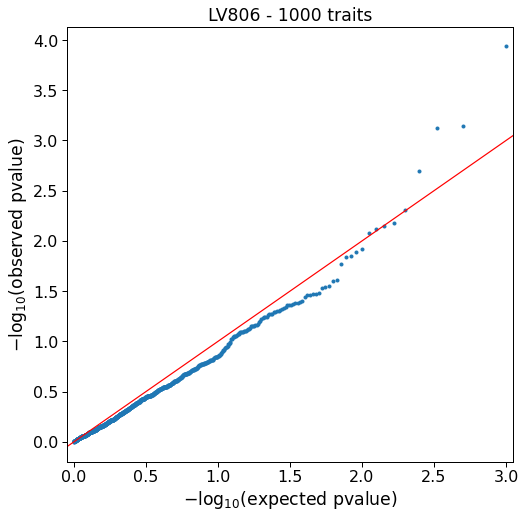

In [102]:
qqplot_unif(results)

# LVs with expected mean type I error

In [103]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
532,LV579,0.014,0.049,0.102
214,LV292,0.013,0.049,0.108
746,LV771,0.014,0.049,0.097
300,LV37,0.011,0.049,0.097
680,LV711,0.015,0.049,0.089
666,LV7,0.011,0.049,0.095
665,LV699,0.015,0.049,0.101
346,LV410,0.012,0.049,0.088
639,LV675,0.011,0.049,0.099
418,LV476,0.014,0.049,0.091


In [104]:
lv_results_expected = {}

## LV412

In [105]:
lv_code = "LV412"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
644,LV412,-0.058743,0.125180,-0.469274,0.638890,0.680555,random.pheno988
1705,LV412,-0.090791,0.125172,-0.725325,0.468279,0.765860,random.pheno589
2017,LV412,0.225917,0.125156,1.805086,0.071108,0.035554,random.pheno385
3153,LV412,0.104079,0.125073,0.832150,0.405355,0.202677,random.pheno5
4024,LV412,0.175094,0.125169,1.398865,0.161902,0.080951,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.014

In [111]:
show_prop(results, 0.05)

0.043

In [112]:
show_prop(results, 0.10)

0.088

In [113]:
show_prop(results, 0.15)

0.123

In [114]:
show_prop(results, 0.20)

0.181

### QQplot

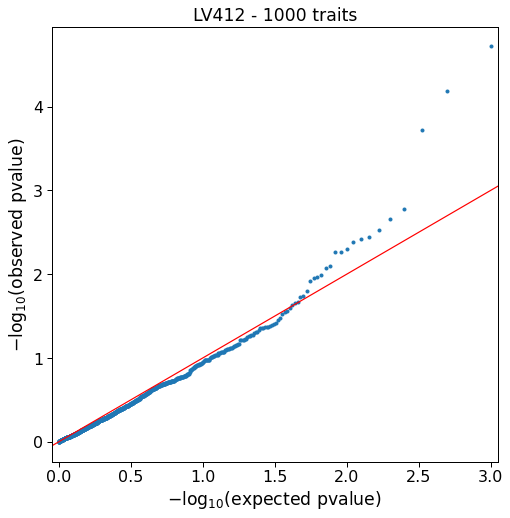

In [115]:
qqplot_unif(results)

## LV57

In [116]:
lv_code = "LV57"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
650,LV57,-0.060530,0.126624,-0.478028,0.632647,0.683677,random.pheno988
1295,LV57,0.050960,0.126496,0.402860,0.687065,0.343532,random.pheno589
2096,LV57,0.142771,0.126621,1.127547,0.259553,0.129777,random.pheno385
3503,LV57,-0.019599,0.126526,-0.154901,0.876904,0.561548,random.pheno5
4288,LV57,0.040389,0.126622,0.318975,0.749756,0.374878,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.013

In [122]:
show_prop(results, 0.05)

0.044

In [123]:
show_prop(results, 0.10)

0.085

In [124]:
show_prop(results, 0.15)

0.134

In [125]:
show_prop(results, 0.20)

0.163

### QQplot

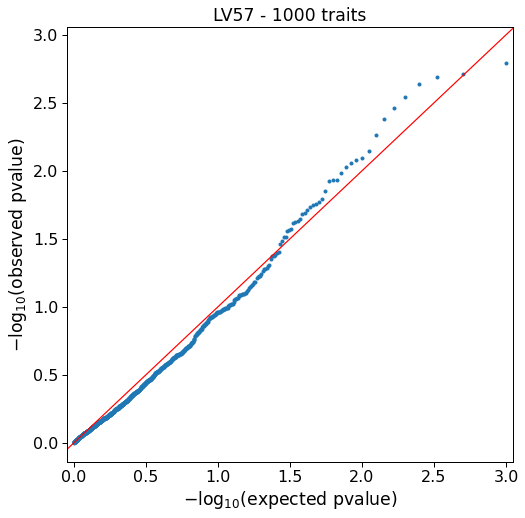

In [126]:
qqplot_unif(results)

## LV647

In [127]:
lv_code = "LV647"

In [128]:
results = dfs[dfs["lv"] == lv_code]

In [129]:
results.shape

(1000, 7)

In [130]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
747,LV647,-0.091655,0.125379,-0.731028,0.464789,0.767606,random.pheno988
1497,LV647,-0.019651,0.125385,-0.156729,0.875463,0.562268,random.pheno589
2621,LV647,-0.056330,0.125389,-0.449239,0.653275,0.673363,random.pheno385
3096,LV647,0.132637,0.125273,1.058785,0.289737,0.144869,random.pheno5
4641,LV647,-0.070916,0.125387,-0.565580,0.571699,0.714150,random.pheno74


In [131]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [132]:
show_prop(results, 0.01)

0.011

In [133]:
show_prop(results, 0.05)

0.051

In [134]:
show_prop(results, 0.10)

0.098

In [135]:
show_prop(results, 0.15)

0.145

In [136]:
show_prop(results, 0.20)

0.195

### QQplot

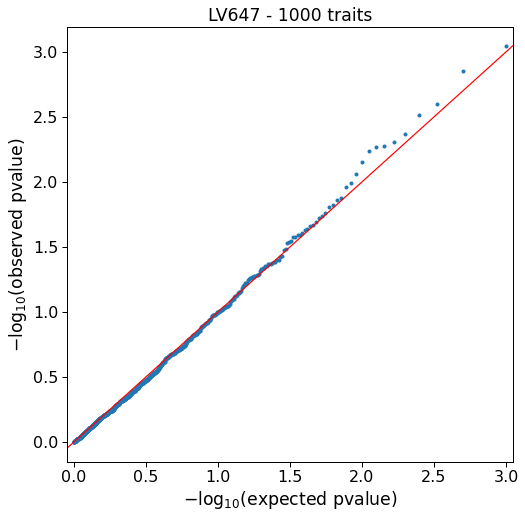

In [137]:
qqplot_unif(results)